In [1]:
from raspberry_listener.remotereader import download_archive
import matplotlib.pyplot as plt
import polars as pl

In [2]:
archive = download_archive()
sensor_combinations = {"humidity": ["DHT11"], "temperature": ["DHT11","PI_CPU", "DS18B20"]}

In [3]:
df = pl.read_parquet(archive, rechunk=False)

In [4]:
def pl_max_mean_min_dataframe(df: pl.DataFrame, sensor_type: str, sensor: str) -> pl.DataFrame:
    lazy_df = df # Operate using lazy api
    single_sensor_df = lazy_df.filter(pl.col("sensor_type").is_in([sensor_type])& pl.col("sensor").is_in([sensor]))

    def median_filter(df: pl.LazyFrame) -> pl.LazyFrame:
        return df.sort(pl.col("timestamp")).groupby_dynamic("timestamp", every="10s", period="20s").agg(pl.col("reading").median())

    filtered_df = median_filter(single_sensor_df)

    def max_mean_min(df: pl.LazyFrame) -> pl.LazyFrame:
        time_col = pl.col("timestamp")
        df_with_time_columns = df.with_columns(time_col.dt.hour().alias("hour"),
                                               time_col.dt.minute().alias("minute"),
                                               time_col.dt.second().alias("second")
                                               )
        df_with_stats = df_with_time_columns.groupby([pl.col("hour"), pl.col("minute"), pl.col("second")]).agg(
            [
                pl.col("timestamp").cast(pl.Time).first(),
                pl.col("reading").min().alias("min"),
                pl.col("reading").mean().alias("mean"),
                pl.col("reading").max().alias("max"),
            ]
        ).sort(pl.col("timestamp"))
        return df_with_stats.select([
            pl.col("timestamp"),
            pl.col("min"),
            pl.col("mean"),
            pl.col("max")
        ])

    return max_mean_min(filtered_df)

In [5]:
def plot_min_mean_max(df: pl.DataFrame, sensor_type: str | None = None, sensor:str | None = None):
    min = df.select(pl.col("min"))
    mean = df.select(pl.col("mean"))
    max = df.select(pl.col("max"))
    timestamps = df.select(pl.col("timestamp").dt.to_string("1900-01-01 - %H:%M:%S").str.to_datetime("%Y-%m-%d - %H:%M:%S"))
    plt.figure()
    plt.plot(timestamps, max)
    plt.plot(timestamps, mean)
    plt.plot(timestamps, min)
    plt.xticks(rotation=30)
    if sensor_type is not None:
        plt.title(f"{sensor_type} - {sensor}")


In [6]:
def plot_min_max(df_pl, sensor_type, sensor):
    max_min_df = pl_max_mean_min_dataframe(df_pl, sensor_type, sensor)
    plot_min_mean_max(max_min_df, sensor_type, sensor)


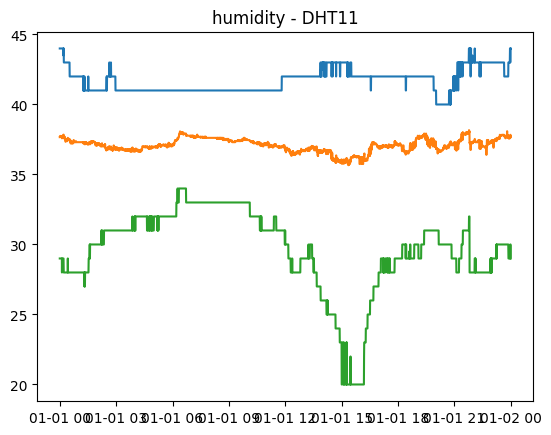

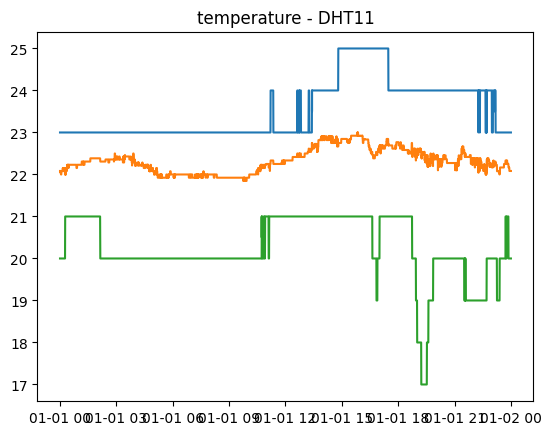

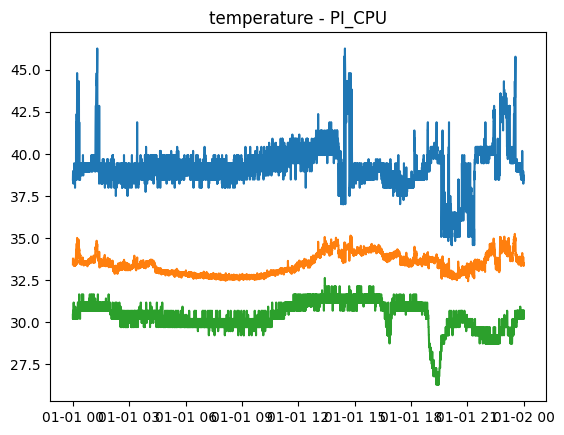

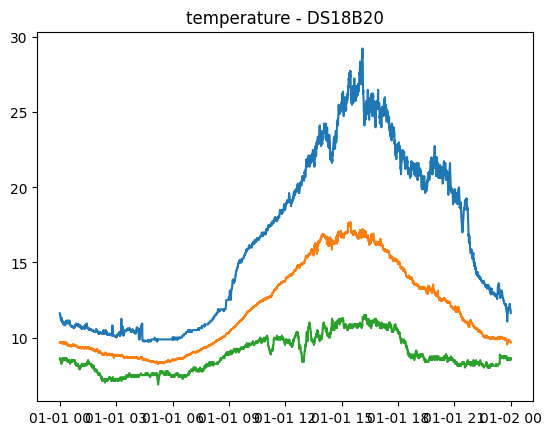

In [7]:
def plot_all():
    for sensor_type, sensors in sensor_combinations.items():
        for sensor in sensors:
            plot_min_max(df, sensor_type, sensor)
plot_all()